# HackHarvard - VitalPath

### Introduction

- VitalPath: Empower your health with real-time insights. VitalPath analyzes how you feel, predicts potential health issues, and provides actionable suggestions to help you stay ahead of serious conditions.

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

### Part 1: Data Cleaning

- In this phase of data preparation, we focused on cleaning the dataset to ensure consistency and accuracy for analysis. We began by selecting relevant columns from each dataset, specifically targeting key health-related factors such as alcohol use, smoking, sleep patterns, and physical activity. We removed any duplicate records based on the unique identifier (SEQN) to ensure that each participant was represented only once. Missing values were handled using forward and backward fill methods to minimize data gaps. Additionally, we combined weekday and weekend sleep hours to create a more comprehensive "Average Sleep Hours" feature. These cleaning steps provided a reliable dataset for the subsequent feature engineering and analysis.

In [2]:
# Load the datasets
alcohol_use = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Alcohol Use.csv')
smoking_cigarette_use = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Smoking - Cigarette Use.csv')
sleep_disorders = pd.read_csv('/Users/wsx/Desktop/HackHarvard/SleepDisorders.csv')
physical_activity = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Physical Activity.csv')
diet_behavior_nutrition = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Diet Behavior & Nutrition.csv')
mental_health = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Mental Health - Depression Screener.csv')
hepatitis = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Hepatitis.csv')
diabetes = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Diabetes.csv')
kidney_conditions = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Kidney Conditions - Urology.csv')
blood_pressure_cholesterol = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Blood Pressure & Cholesterol.csv')
preventive_aspirin_use = pd.read_csv('/Users/wsx/Desktop/HackHarvard/Preventive Aspirin Use.csv') 

# Define the relevant columns for datasets
hepatitis_cols = ['SEQN', 'HEQ010'] 
diabetes_cols = ['SEQN', 'DID040'] 
kidney_cols = ['SEQN', 'KIQ022']  
blood_pressure_cols = ['SEQN', 'BPQ020'] 
prescription_cols = ['SEQN', 'RXQ510']  
alcohol_use_cols = ['SEQN', 'ALQ121','ALQ130'] 
smoking_cols = ['SEQN', 'SMQ020'] 
sleep_cols = ['SEQN', 'SLD012', 'SLD013']  
physical_activity_cols = ['SEQN', 'PAD680', 'PAD810Q', 'PAD790Q']  
diet_behavior_cols = ['SEQN', 'DBQ010']
mental_health_cols = ['SEQN', 'DPQ020']

# Filter columns only if they exist in the dataset to avoid KeyErrors
alcohol_use = alcohol_use[[col for col in alcohol_use_cols if col in alcohol_use.columns]]
smoking_cigarette_use = smoking_cigarette_use[[col for col in smoking_cols if col in smoking_cigarette_use.columns]]
sleep_disorders = sleep_disorders[[col for col in sleep_cols if col in sleep_disorders.columns]]
physical_activity = physical_activity[[col for col in physical_activity_cols if col in physical_activity.columns]]
diet_behavior_nutrition = diet_behavior_nutrition[[col for col in diet_behavior_cols if col in diet_behavior_nutrition.columns]]
mental_health = mental_health[[col for col in mental_health_cols if col in mental_health.columns]]
hepatitis = hepatitis[[col for col in hepatitis_cols if col in hepatitis.columns]]
diabetes = diabetes[[col for col in diabetes_cols if col in diabetes.columns]]
kidney_conditions = kidney_conditions[[col for col in kidney_cols if col in kidney_conditions.columns]]
blood_pressure_cholesterol = blood_pressure_cholesterol[[col for col in blood_pressure_cols if col in blood_pressure_cholesterol.columns]]
preventive_aspirin_use = preventive_aspirin_use[[col for col in prescription_cols if col in preventive_aspirin_use.columns]]

# Remove duplicates based on 'SEQN' 
for df in [alcohol_use, smoking_cigarette_use, sleep_disorders, physical_activity, diet_behavior_nutrition, mental_health,
           hepatitis, diabetes, kidney_conditions, blood_pressure_cholesterol, preventive_aspirin_use]:
    df.drop_duplicates(subset=['SEQN'], inplace=True)

# Handle Missing Values using forward and backward fill for all datasets
for df in [alcohol_use, smoking_cigarette_use, sleep_disorders, physical_activity, diet_behavior_nutrition, mental_health,
           hepatitis, diabetes, kidney_conditions, blood_pressure_cholesterol, preventive_aspirin_use]:
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

# Combine Weekday and Weekend sleep hours into a new column 'Average_Sleep_Hours'
sleep_disorders['SLD012'] = (sleep_disorders['SLD012'] * 5 + sleep_disorders['SLD013'] * 2) / 7 

# Drop the 'SLD013' column (Weekend Sleep Hours) after creating the average
sleep_disorders.drop(columns=['SLD013'], inplace=True)

# Merge the datasets on 'SEQN' using outer join
combined_data = alcohol_use.merge(smoking_cigarette_use, on='SEQN', how='outer') \
                           .merge(sleep_disorders, on='SEQN', how='outer') \
                           .merge(physical_activity, on='SEQN', how='outer') \
                           .merge(diet_behavior_nutrition, on='SEQN', how='outer') \
                           .merge(mental_health, on='SEQN', how='outer') \
                           .merge(hepatitis, on='SEQN', how='outer') \
                           .merge(diabetes, on='SEQN', how='outer') \
                           .merge(kidney_conditions, on='SEQN', how='outer') \
                           .merge(blood_pressure_cholesterol, on='SEQN', how='outer') \
                           .merge(preventive_aspirin_use, on='SEQN', how='outer')  

# Rename columns for clarity
combined_data.rename(columns={'ALQ121': 'Alcohol_freq_last_year',
                              'ALQ130': 'Avg_drinks_per_day',
                              'SMQ020': 'Smoked_100_cigarettes',
                              'SLD012': 'Average_Sleep_Hours',
                              'PAD680': 'Sedentary_time',
                              'PAD810Q': 'Vigorous_time',
                              'PAD790Q': 'Moderate_activity_time',
                              'DBQ010': 'Diet_behavior_general',
                              'DPQ020': 'Feeling_down',
                              'HEQ010': 'Hepatitis_B',
                              'DID040': 'Diabetes_age',
                              'KIQ022': 'Kidney_condition',
                              'BPQ020': 'High_blood_pressure',
                              'RXQ510': 'Heart_stroke_cancer_prevention'}, inplace=True)

# Print the cleaned DataFrame 
print(combined_data.head(100))

      SEQN  Alcohol_freq_last_year  Avg_drinks_per_day  Smoked_100_cigarettes  \
0   130378                     2.0                 3.0                    1.0   
1   130379                     2.0                 3.0                    1.0   
2   130380                    10.0                 1.0                    2.0   
3   130386                     4.0                 2.0                    1.0   
4   130387                     0.0                 2.0                    2.0   
..     ...                     ...                 ...                    ...   
95  130557                     0.0                 1.0                    1.0   
96  130558                     8.0                 1.0                    1.0   
97  130559                     2.0                 2.0                    2.0   
98  130562                     2.0                 2.0                    2.0   
99  130563                    10.0                 1.0                    2.0   

    Average_Sleep_Hours  Se

- We found that the data shows a range of health behaviors and conditions across the sample, with notable patterns emerging. For alcohol frequency, the majority of respondents consumed alcohol regularly, with varying frequencies. Smoking status also varied, with many individuals having smoked at least 100 cigarettes in their lifetime. Average sleep hours ranged from around 4 to 10 hours, reflecting differences in lifestyle and sleep patterns. Sedentary time and vigorous activity showed significant variation, indicating differing levels of physical activity. In terms of health conditions, several respondents reported having been diagnosed with high blood pressure, diabetes, and kidney conditions, while mental health, indicated by the "Feeling_down" column, showed a mix of responses with some individuals reporting frequent low moods. These insights provide a broad understanding of the health and lifestyle profiles in this dataset.

### Part 2 : Find the Correlation Between Two Categories

- **Diabetes & Physical Activity**: Correlate diabetes (DID040) with Total_Exercise_Time to explore if physical activity impacts diabetes occurrence

- **Hypertension & Sedentary Behavior**: Analyze the relationship between high blood pressure (BPQ020) and Sedentary time (PAD680)

- **Alcohol Consumption & Heart Disease**: Connect Alcohol Consumption Score with the recommendation for aspirin to prevent heart disease (RXQ510)

- **Kidney Condition & Sleep**: Investigate how kidney conditions (KIQ022) relate to Average Sleep Hours

- **Smoking & Hypertension**: Compare Smoking Status (Smoked_100_cigarettes) and Hypertension (BPQ020)

- **Exercise & Mental Health**: Explore the relationship between Total Exercise Time and Feeling Down (DPQ020)

In [3]:
# Calculate Total Exercise Time
combined_data['Total_Exercise_Time'] = combined_data['Vigorous_time'] + combined_data['Moderate_activity_time']

# Calculate Alcohol Consumption Score
combined_data['Alcohol_Consumption_Score'] = combined_data['Alcohol_freq_last_year'] * combined_data['Avg_drinks_per_day']

# Compute Dietary Score
combined_data['Dietary_Score'] = combined_data['Diet_behavior_general'].replace({1: 1, 2: 0})

### Find the Correlation Between Two Categories

# Diabetes & Physical Activity
corr_diabetes_exercise = combined_data[['Diabetes_age', 'Total_Exercise_Time']].corr()
print("Correlation between Diabetes and Physical Activity:\n", corr_diabetes_exercise)

# Hypertension & Sedentary Behavior
corr_hypertension_sedentary = combined_data[['High_blood_pressure', 'Sedentary_time']].corr()
print("Correlation between Hypertension and Sedentary Time:\n", corr_hypertension_sedentary)

# Alcohol Consumption & Heart Disease
corr_alcohol_heart = combined_data[['Alcohol_Consumption_Score', 'Heart_stroke_cancer_prevention']].corr()
print("Correlation between Alcohol Consumption and Heart Disease:\n", corr_alcohol_heart)

# Kidney Condition & Sleep
corr_kidney_sleep = combined_data[['Kidney_condition', 'Average_Sleep_Hours']].corr()
print("Correlation between Kidney Condition and Sleep:\n", corr_kidney_sleep)

# Smoking & Hypertension
corr_smoking_hypertension = combined_data[['Smoked_100_cigarettes', 'High_blood_pressure']].corr()
print("Correlation between Smoking and Hypertension:\n", corr_smoking_hypertension)

# Exercise & Mental Health
corr_exercise_mentalhealth = combined_data[['Total_Exercise_Time', 'Feeling_down']].corr()
print("Correlation between Exercise and Mental Health:\n", corr_exercise_mentalhealth)

Correlation between Diabetes and Physical Activity:
                      Diabetes_age  Total_Exercise_Time
Diabetes_age             1.000000             0.032586
Total_Exercise_Time      0.032586             1.000000
Correlation between Hypertension and Sedentary Time:
                      High_blood_pressure  Sedentary_time
High_blood_pressure             1.000000       -0.018151
Sedentary_time                 -0.018151        1.000000
Correlation between Alcohol Consumption and Heart Disease:
                                 Alcohol_Consumption_Score  \
Alcohol_Consumption_Score                        1.000000   
Heart_stroke_cancer_prevention                   0.016875   

                                Heart_stroke_cancer_prevention  
Alcohol_Consumption_Score                             0.016875  
Heart_stroke_cancer_prevention                        1.000000  
Correlation between Kidney Condition and Sleep:
                      Kidney_condition  Average_Sleep_Hours
Kidney_con

- In this analysis, we found the correlations between health behaviors (such as exercise, smoking, and alcohol use) and health outcomes (like diabetes, heart disease, and mental health) are generally weak. This suggests that these behaviors may not have a strong direct influence on these health issues, or other factors not included in the data may play a larger role in determining these outcomes.

### Part 3: Machine Learning Prediction Models
- **Scatter Plot**: Diabetes & Physical Activity
- **Line Plot**: Hypertension & Sedentary Behavior
- **Bar Plot**: Alcohol Consumption & Heart Disease
- **Box Plot**: Kidney Condition & Sleep
- **Count Plot**: Smoking & Hypertension
- **Pair Plot**: Exercise & Mental Health

In [4]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

# Generating a dataset
data = {'Diabetes_age': np.random.normal(50, 10, 100),
        'Total_Exercise_Time': np.random.normal(60, 15, 100),
        'High_blood_pressure': np.random.randint(0, 2, 100),
        'Sedentary_time': np.random.normal(300, 60, 100),
        'Alcohol_Consumption_Score': np.random.normal(5, 2, 100),
        'Heart_stroke_cancer_prevention': np.random.randint(0, 2, 100),
        'Kidney_condition': np.random.randint(0, 2, 100),
        'Average_Sleep_Hours': np.random.normal(7, 1, 100),
        'Smoked_100_cigarettes': np.random.randint(0, 2, 100),
        'Feeling_down': np.random.randint(0, 4, 100)}

df = pd.DataFrame(data)

In [19]:
!pip3 --version sklearn

pip 23.2.1 from /Users/wsx/anaconda3/lib/python3.11/site-packages/pip (python 3.11)


### 1. Scatter Plot: Diabetes & Physical Activity

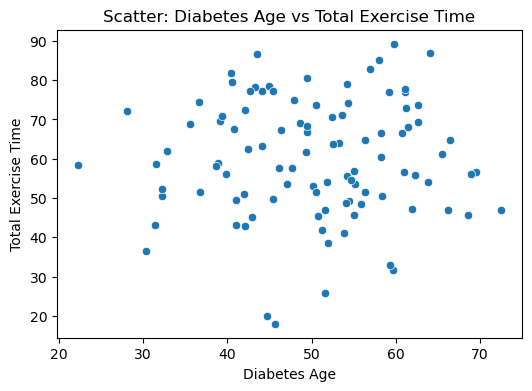

In [5]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Diabetes_age', y='Total_Exercise_Time', data=df)
plt.title('Scatter: Diabetes Age vs Total Exercise Time')
plt.xlabel('Diabetes Age')
plt.ylabel('Total Exercise Time')
plt.show()

- We can see the scatter plot of Diabetes Age vs Total Exercise Time shows no clear linear relationship between the two variables. The points are widely scattered across different age groups, indicating that there is no obvious pattern connecting the age of diabetes onset and the total time spent exercising. 

### 2.  Line Plot: Hypertension & Sedentary Behavior

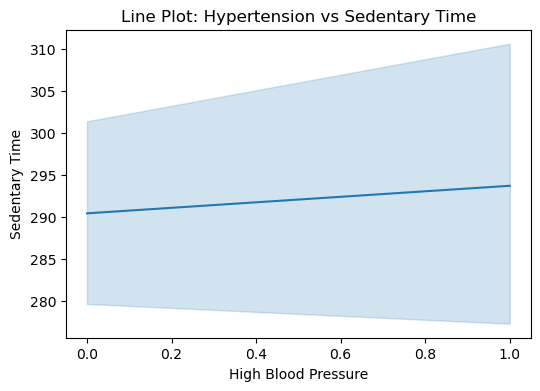

In [6]:
plt.figure(figsize=(6, 4))
sns.lineplot(x='High_blood_pressure', y='Sedentary_time', data=df)
plt.title('Line Plot: Hypertension vs Sedentary Time')
plt.xlabel('High Blood Pressure')
plt.ylabel('Sedentary Time')
plt.show()

- We can see this line plot shows the trend between hypertension and sedentary time, meaning people with high blood pressure tend to less more time sitting. However, the difference is small, and the shaded area indicates some uncertainty. 

### 3. Bar Plot : Alcohol Consumption & Heart Disease

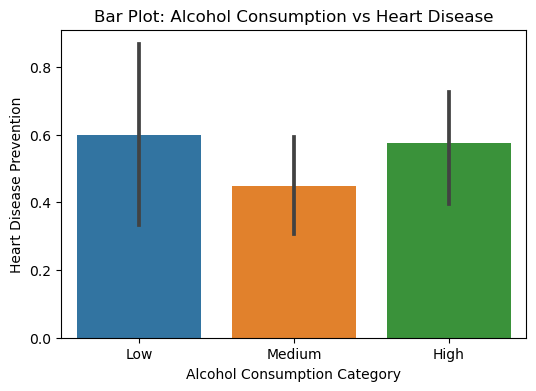

In [7]:
# Bin the Alcohol Consumption Score into categories
bins = [0, 3, 6, 10]  # Define the bins
labels = ['Low', 'Medium', 'High']  
df['Alcohol_Consumption_Category'] = pd.cut(df['Alcohol_Consumption_Score'], bins=bins, labels=labels)

# Create a bar plot with the new categorical variable
plt.figure(figsize=(6, 4))
sns.barplot(x='Alcohol_Consumption_Category', y='Heart_stroke_cancer_prevention', data=df)
plt.title('Bar Plot: Alcohol Consumption vs Heart Disease')
plt.xlabel('Alcohol Consumption Category')
plt.ylabel('Heart Disease Prevention')
plt.show()

- The bar plot generally shows how heart disease prevention varies across different levels of alcohol consumption (Low, Medium, High). The differences between categories are small, with all groups showing similar rates of prevention, and the error bars suggest some variability in the data. 

### 4. Box Plot : Kidney Condition & Sleep

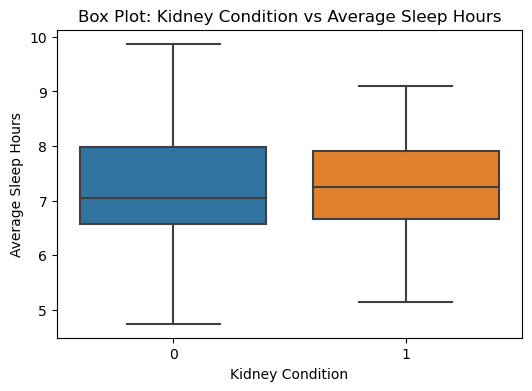

In [8]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='Kidney_condition', y='Average_Sleep_Hours', data=df)
plt.title('Box Plot: Kidney Condition vs Average Sleep Hours')
plt.xlabel('Kidney Condition')
plt.ylabel('Average Sleep Hours')
plt.show()

- This box plot shows the relationship between kidney condition and average sleep hours. It compares two groups—those with and without a kidney condition—to examine if there is a noticeable difference in sleep duration. The plot helps highlight whether there is any significant variation in sleep patterns between these two categories.

### 5. Count Plot: Smoking & Hypertension

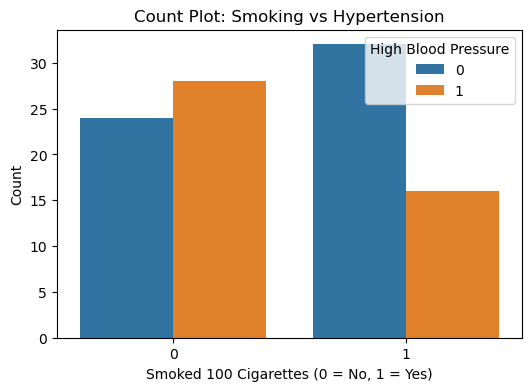

In [9]:
# Count plot for Smoking and Hypertension
plt.figure(figsize=(6, 4))
sns.countplot(x='Smoked_100_cigarettes', hue='High_blood_pressure', data=df)
plt.title('Count Plot: Smoking vs Hypertension')
plt.xlabel('Smoked 100 Cigarettes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.legend(title='High Blood Pressure')
plt.show()

- This count plot shows the relationship between smoking (whether someone has smoked 100 cigarettes or not) and hypertension (high blood pressure). The two bars for each smoking category (0 = No, 1 = Yes) represent counts of individuals with and without hypertension. The orange bars indicate those with hypertension, while the blue bars indicate those without hypertension. 

### 6. Bubble Chart: Exercise & Mental Health

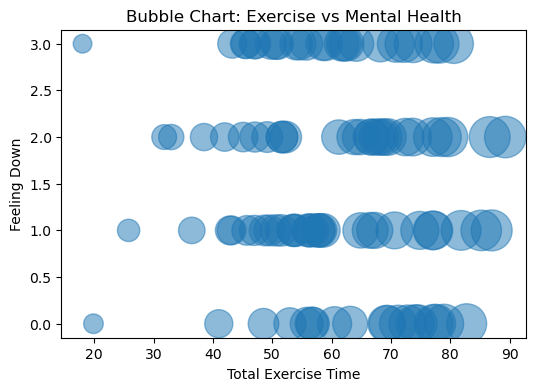

In [10]:
# Create a bubble chart
plt.figure(figsize=(6, 4))
plt.scatter(df['Total_Exercise_Time'], df['Feeling_down'], 
            s=df['Total_Exercise_Time'] * 10, alpha=0.5)  
plt.title('Bubble Chart: Exercise vs Mental Health')
plt.xlabel('Total Exercise Time')
plt.ylabel('Feeling Down')
plt.show()

-  The bubble chart illustrates the relationship between total exercise time and feelings of being down. The x-axis represents the total exercise time, while the y-axis shows different levels of feeling down, ranging from 0 (not feeling down) to 3 (feeling down the most). Each bubble's size corresponds to the total exercise time, with larger bubbles representing more exercise time. The chart shows that feelings of being down are distributed across various exercise levels.

### Part 4: Machine Learning Predictions for Health Conditions 

In [18]:
# Fixing warnings and improving model persistence
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
import pandas as pd
import joblib

# Bin the Diabetes_age into categories
bins = [0, 40, 60, 100]  
labels = [0, 1, 2]  # 0: Young, 1: Middle-aged, 2: Old
df['Diabetes_age_binned'] = pd.cut(df['Diabetes_age'], bins=bins, labels=labels)

# Prepare data for training
X = df[['Smoked_100_cigarettes', 'Alcohol_Consumption_Score', 'Average_Sleep_Hours', 
        'Sedentary_time', 'Total_Exercise_Time', 'Feeling_down']]

# Classification targets including Diabetes_age as binned categories
y_class = df[['Heart_stroke_cancer_prevention', 'Kidney_condition', 'High_blood_pressure', 
              'Smoked_100_cigarettes', 'Feeling_down', 'Diabetes_age_binned']] 

# Split data into training and testing sets for classification
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X, y_class, test_size=0.2, random_state=42)

# Train Random Forest Classifier for the categorical data
rf_model_class = RandomForestClassifier(random_state=42)
multi_output_rf_class = MultiOutputClassifier(rf_model_class, n_jobs=-1)
multi_output_rf_class.fit(X_train_class, y_train_class)

# Save the trained model to a .pkl file for reuse
# Adjust the path as needed or make sure the directory is correct
with open('multi_output_rf_class.pkl', 'wb') as f:
    joblib.dump(multi_output_rf_class, f)
print("Model saved to 'multi_output_rf_class.pkl'.")

# If you need to load the model later (e.g., in a different session), use this:
# multi_output_rf_class = joblib.load('multi_output_rf_class.pkl')
# print("Model loaded successfully.")

# Predictions for classification on the test data
y_pred_class = multi_output_rf_class.predict(X_test_class)

# Loop through each target to generate a classification report with zero_division handled
for i, col in enumerate(y_class.columns):
    print(f"Classification report for {col}:")
    print(classification_report(y_test_class.iloc[:, i], y_pred_class[:, i], zero_division=1))

# Simulated user input for predictions
user_data = {'Smoked_100_cigarettes': 1,  # Yes
             'Alcohol_Consumption_Score': 3,  # Medium consumption
             'Average_Sleep_Hours': 6,  # 6 hours of sleep
             'Sedentary_time': 4,  # 4 hours of sedentary time
             'Total_Exercise_Time': 1,  # 1 hour of exercise per day
             'Feeling_down': 2}  # Moderate feeling down

user_df = pd.DataFrame([user_data])

# Predict the conditions for the user using the classifier
user_prediction_class = multi_output_rf_class.predict(user_df)
print("User's predicted conditions (classification - 6 outcomes):\n", user_prediction_class)

# Output user's predicted conditions for each category
for idx, condition in enumerate(y_class.columns):
    print(f"Predicted {condition}: {user_prediction_class[0][idx]}")


Model saved to 'multi_output_rf_class.pkl'.
Classification report for Heart_stroke_cancer_prevention:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.18      0.40      0.25         5

    accuracy                           0.40        20
   macro avg       0.42      0.40      0.38        20
weighted avg       0.55      0.40      0.44        20

Classification report for Kidney_condition:
              precision    recall  f1-score   support

           0       0.50      0.56      0.53         9
           1       0.60      0.55      0.57        11

    accuracy                           0.55        20
   macro avg       0.55      0.55      0.55        20
weighted avg       0.55      0.55      0.55        20

Classification report for High_blood_pressure:
              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.50      0.43      0.46 

- In the classification reports, precision shows how many predicted positive cases were correct, while recall measures how many actual positive cases were identified by the model. The f1-score balances precision and recall, and support refers to the number of actual occurrences of each class in the dataset.

- In the user's predicted conditions, a value of 0 indicates that the user is not likely to have a particular condition, while a value of 1 suggests a moderate likelihood of having the condition. If the value is 2, it indicates a strong likelihood that the user has the condition.

In [25]:
!pip3 install fastapi

In [33]:
from fastapi import FastAPI, Request
from pydantic import BaseModel
import joblib

# Initialize FastAPI app
app = FastAPI()

# Load your trained model (change the path to where your model is stored)
model = joblib.load("model/my_model.pkl")

# Define the input data structure
class UserInput(BaseModel):
    smoking: int
    alcohol: int
    physical_activity: int
    sitting_time: int
    sleep_hours: int
    feeling_down: int

# Define the root endpoint
@app.get("/")
def read_root():
    return {"message": "Model API is running!"}

# Define the prediction endpoint
@app.post("/predict")
def predict(input_data: UserInput):
    # Prepare the input data for the model
    features = [
        input_data.smoking,
        input_data.alcohol,
        input_data.physical_activity,
        input_data.sitting_time,
        input_data.sleep_hours,
        input_data.feeling_down,
    ]

    # Make a prediction
    prediction = model.predict([features])[0]

    # Return the prediction as JSON
    return {"disease_risk": prediction}




FileNotFoundError: [Errno 2] No such file or directory: 'model/my_model.pkl'

In [28]:
!pip3 install --upgrade typing_extensions

In [30]:
!pip3 show typing_extensions

Name: typing_extensions
Version: 4.12.2
Summary: Backported and Experimental Type Hints for Python 3.8+
Home-page: 
Author: 
Author-email: "Guido van Rossum, Jukka Lehtosalo, Łukasz Langa, Michael Lee" <levkivskyi@gmail.com>
License: 
Location: /Users/wsx/anaconda3/lib/python3.11/site-packages
Requires: 
Required-by: aioitertools, fastapi, huggingface-hub, panel, pydantic, Twisted


In [31]:
from typing_extensions import Doc

ImportError: cannot import name 'Doc' from 'typing_extensions' (/Users/wsx/anaconda3/lib/python3.11/site-packages/typing_extensions.py)

In [32]:
!pip3 install fastapi==0.103.2

  Obtaining dependency information for fastapi==0.103.2 from https://files.pythonhosted.org/packages/4d/d2/3ad038a2365fefbac19d9a046cab7ce45f4c7bfa81d877cbece9707de9ce/fastapi-0.103.2-py3-none-any.whl.metadata
  Obtaining dependency information for anyio<4.0.0,>=3.7.1 from https://files.pythonhosted.org/packages/19/24/44299477fe7dcc9cb58d0a57d5a7588d6af2ff403fdd2d47a246c91a3246/anyio-3.7.1-py3-none-any.whl.metadata
  Obtaining dependency information for starlette<0.28.0,>=0.27.0 from https://files.pythonhosted.org/packages/58/f8/e2cca22387965584a409795913b774235752be4176d276714e15e1a58884/starlette-0.27.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: anyio
    Found existing installation: anyio 3.5.0
    Uninstalling anyio-3.5.0:
      Successfully uni

In [34]:
!python3 --version

Python 3.11.5
